In [1]:
import sys
import importlib
import pickle

# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data analysis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# pytorch specific
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# project specific
sys.path.append('../')
from src import config
from src.utils import visualisation, benchmark, helpers, monitoring
from src.models import torch_CVAE


from matplotlib.animation import FuncAnimation
from IPython.display import HTML

pd.options.display.width = 1000
DEVICE = torch.device(config["DEVICE"])

In [2]:
importlib.reload(helpers)

#with open('../workfiles/BRCA_ds.pkl', 'rb') as f:
with open('../workfiles/light_BRCA_ds.pkl', 'rb') as f:
    data, metadata = pickle.load(f)

feature_num = len(metadata["feature_names"])
print(feature_num)

3242


In [3]:
importlib.reload(helpers)
data_set, dataloader = helpers.format_dataset(data, metadata, 0.01)

(1231, 3242)
(1231, 1, 3242)
train data: 1231


In [4]:
def find_primes(n):
    primes = []
    for i in range(1,n):
        if n % i == 0:
            primes.append(i)
    return primes

In [5]:
primes = find_primes(feature_num)
num_heads = primes[-1]

In [6]:
feature_num /num_heads

2.0

In [17]:
importlib.reload(torch_CVAE)

latent_dim = 64
model = torch_CVAE.Autoencoder(
    shape = feature_num,
    dropout = 0.2,
    latent_dim = latent_dim,
    is_variational = False,
    full_attention= True,
    num_heads=num_heads,
    num_layers= 1,
    )
#model.add_self_attention(0.4)
#model.add_attention()


optimizer = optim.Adam(model.parameters(), lr=1e-4, amsgrad=False)


#benchmark.count_parameters(model)
#Trainable parameters: 21255169




model.to(DEVICE)
print("")


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [18]:
importlib.reload(monitoring)
importlib.reload(helpers)
monitor = monitoring.Monitor(model, dataloader, label = metadata["subtypes"])

callbacks = monitor.callbacks

0.0001


  0%|          | 9/10000 [00:10<2:12:57,  1.25it/s] 

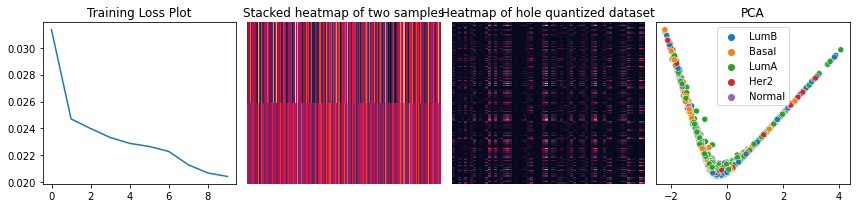

  0%|          | 10/10000 [00:11<2:44:04,  1.01it/s]

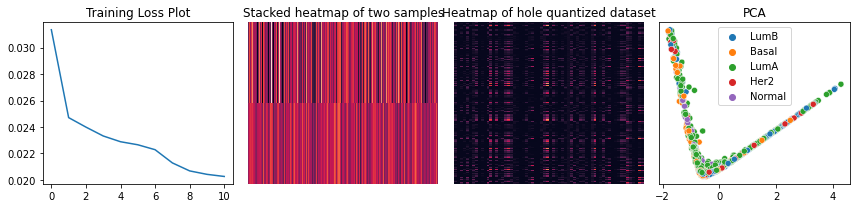

  0%|          | 12/10000 [00:13<2:41:29,  1.03it/s]

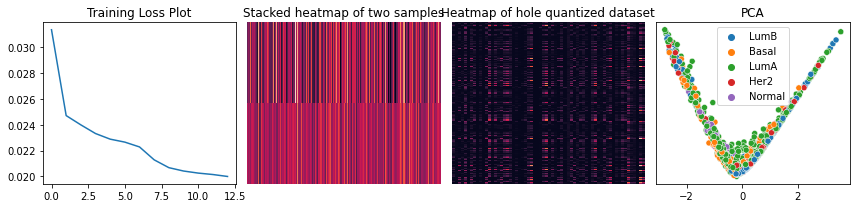

  0%|          | 14/10000 [00:15<2:40:40,  1.04it/s]

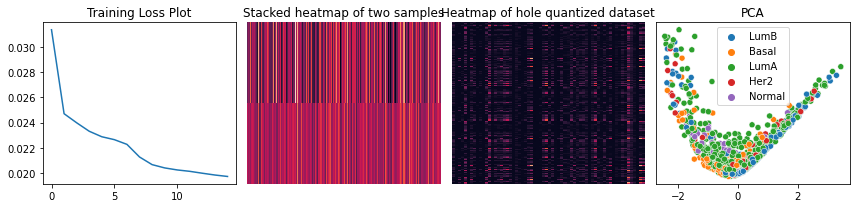

  0%|          | 16/10000 [00:18<3:03:45,  1.10s/it]

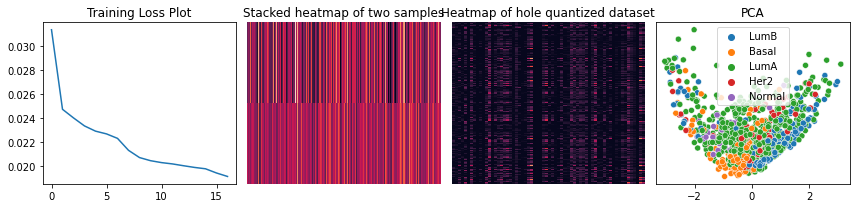

  0%|          | 19/10000 [00:21<2:36:42,  1.06it/s]

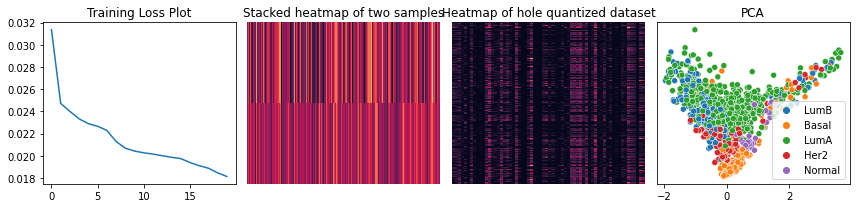

  0%|          | 22/10000 [00:23<2:30:16,  1.11it/s]

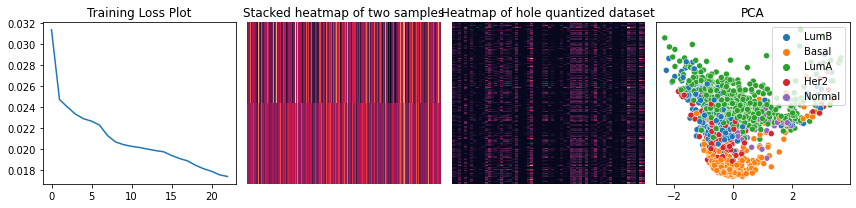

  0%|          | 25/10000 [00:27<2:44:42,  1.01it/s]

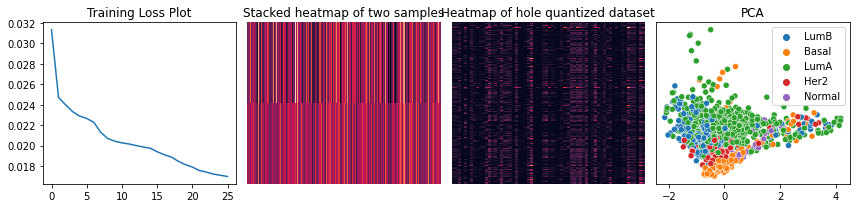

  0%|          | 29/10000 [00:31<2:46:24,  1.00s/it]

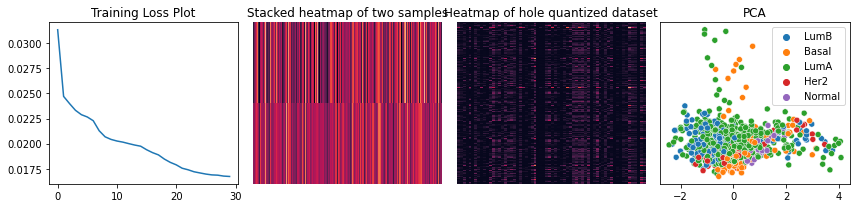

  0%|          | 34/10000 [00:36<2:27:59,  1.12it/s]

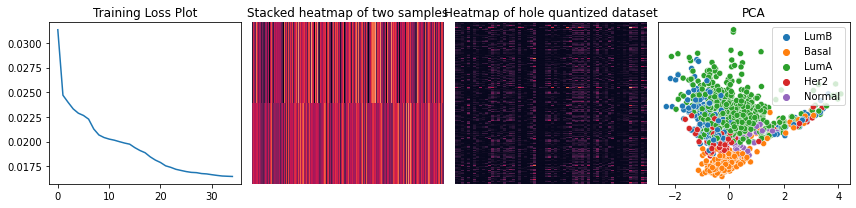

  0%|          | 39/10000 [00:40<2:14:32,  1.23it/s]

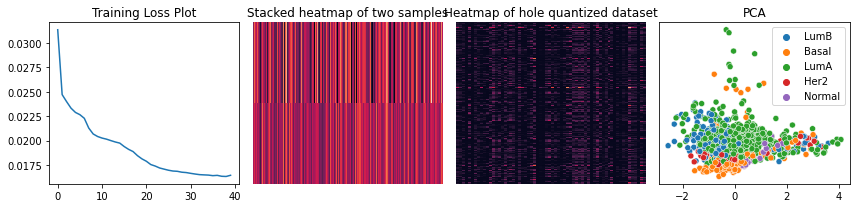

  0%|          | 46/10000 [00:46<2:06:03,  1.32it/s]

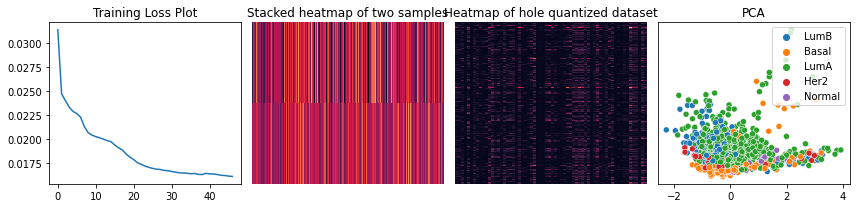

  1%|          | 53/10000 [00:52<2:05:13,  1.32it/s]

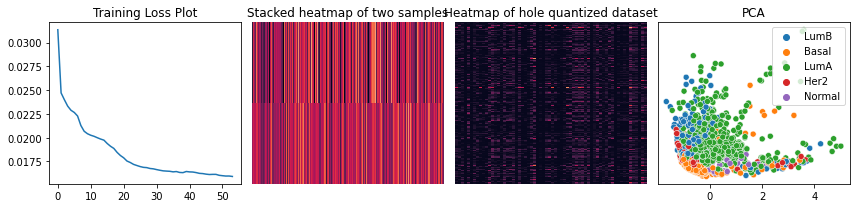

  1%|          | 61/10000 [00:58<2:00:34,  1.37it/s]

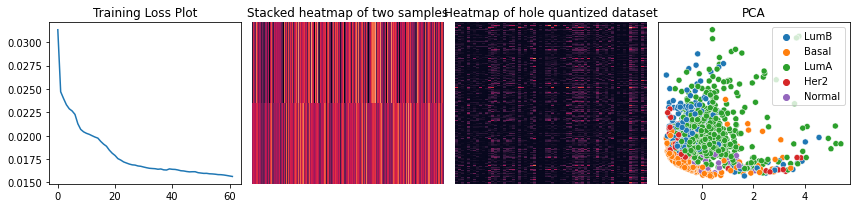

  1%|          | 70/10000 [01:05<2:05:19,  1.32it/s]

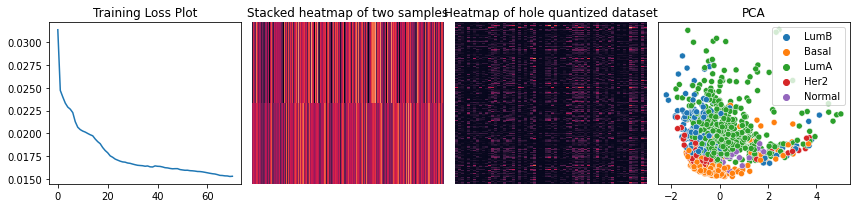

  1%|          | 81/10000 [01:14<2:01:57,  1.36it/s]

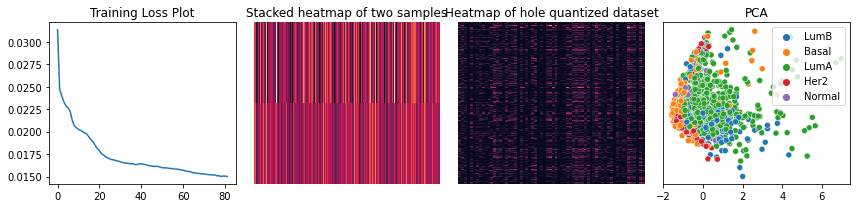

  1%|          | 94/10000 [01:24<2:01:17,  1.36it/s]

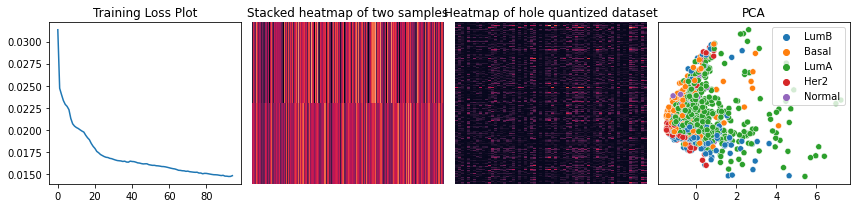

  1%|          | 108/10000 [01:35<2:01:22,  1.36it/s]

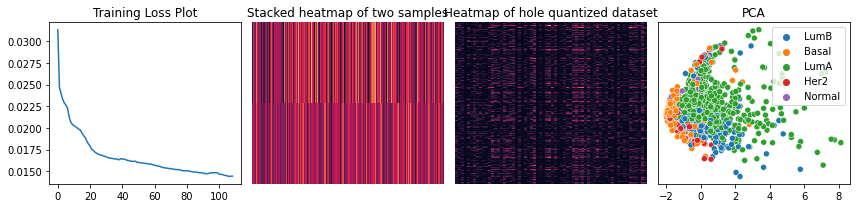

  1%|▏         | 125/10000 [01:47<1:57:34,  1.40it/s]

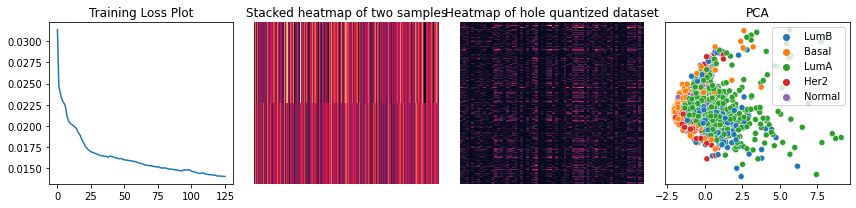

  1%|▏         | 144/10000 [02:01<1:53:46,  1.44it/s]

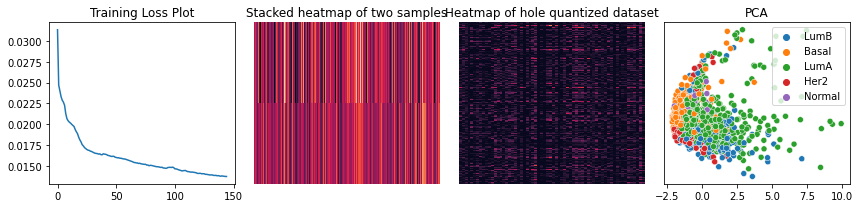

  2%|▏         | 166/10000 [02:17<1:53:47,  1.44it/s]

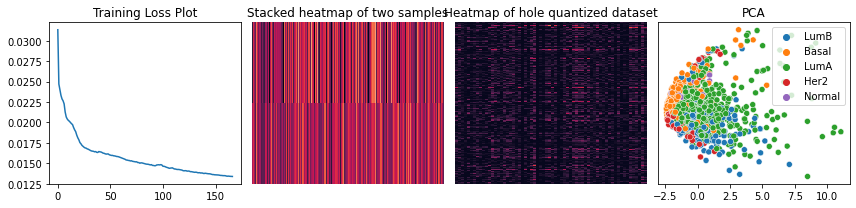

  2%|▏         | 192/10000 [02:36<1:54:05,  1.43it/s]

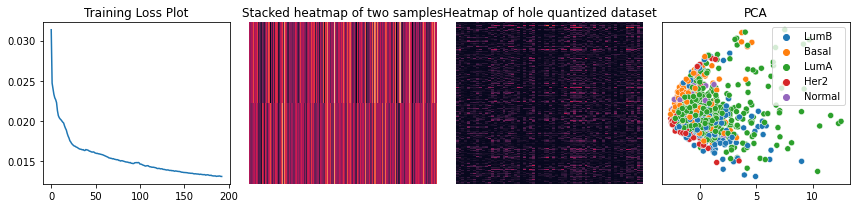

  2%|▏         | 221/10000 [02:57<1:54:26,  1.42it/s]

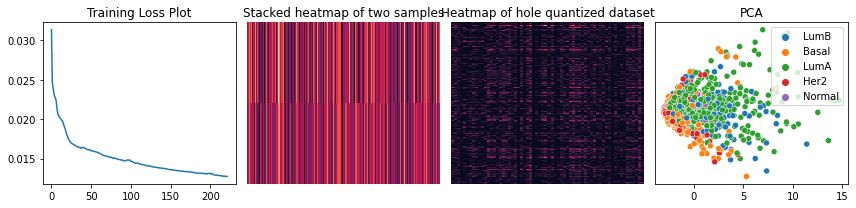

  3%|▎         | 254/10000 [03:20<1:52:26,  1.44it/s]

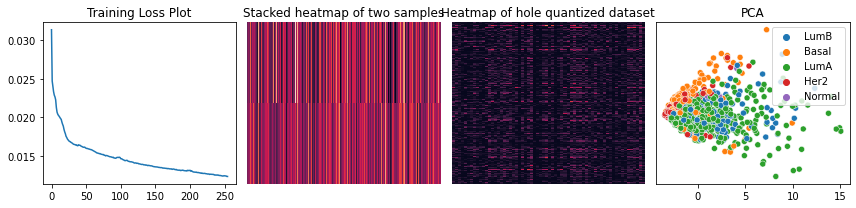

  3%|▎         | 293/10000 [03:48<1:53:44,  1.42it/s]

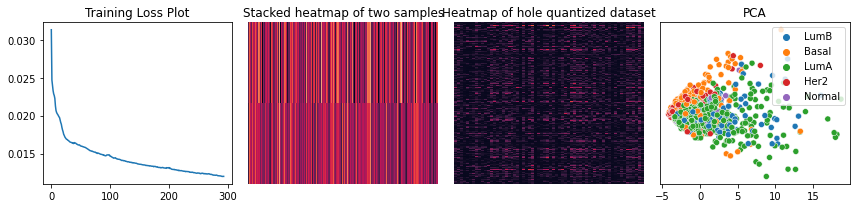

  3%|▎         | 338/10000 [04:21<1:53:13,  1.42it/s]

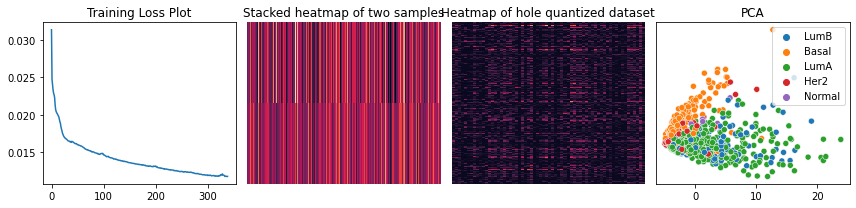

  4%|▍         | 389/10000 [05:00<2:12:10,  1.21it/s]

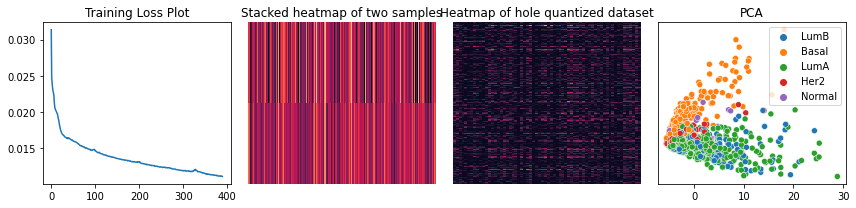

  4%|▍         | 448/10000 [05:44<1:53:09,  1.41it/s]

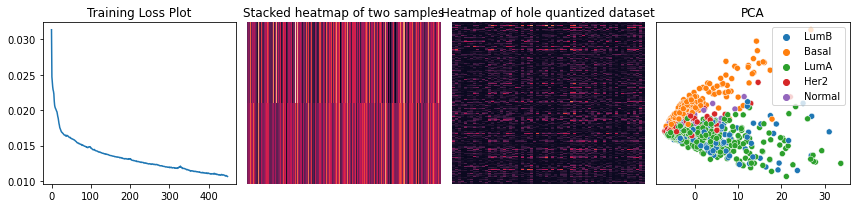

  5%|▌         | 516/10000 [06:33<1:48:34,  1.46it/s]

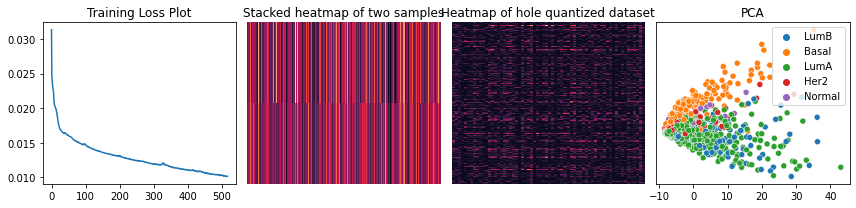

  6%|▌         | 595/10000 [07:29<1:51:25,  1.41it/s]

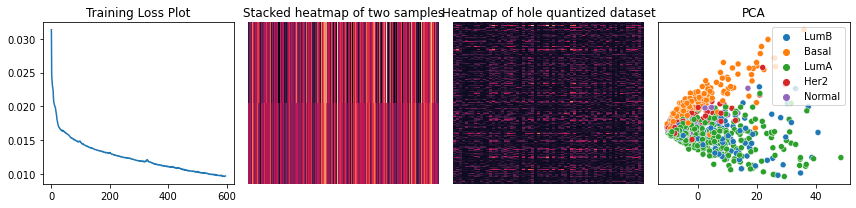

  7%|▋         | 685/10000 [08:34<1:52:42,  1.38it/s]

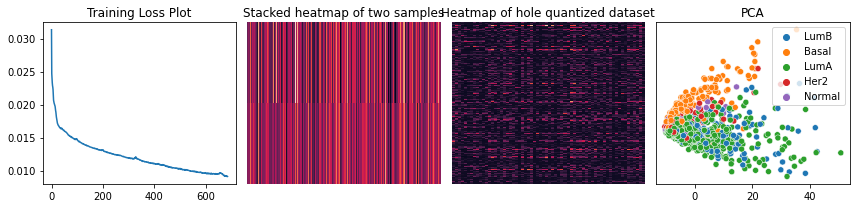

  8%|▊         | 789/10000 [09:46<1:45:02,  1.46it/s]

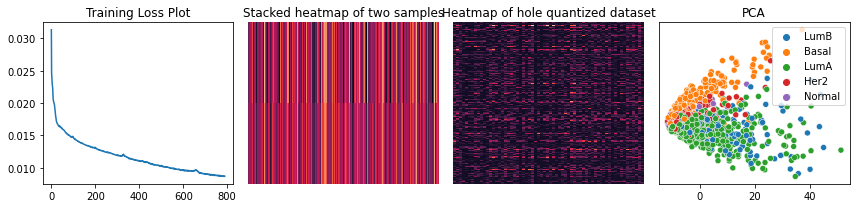

  9%|▉         | 909/10000 [11:10<1:45:20,  1.44it/s]

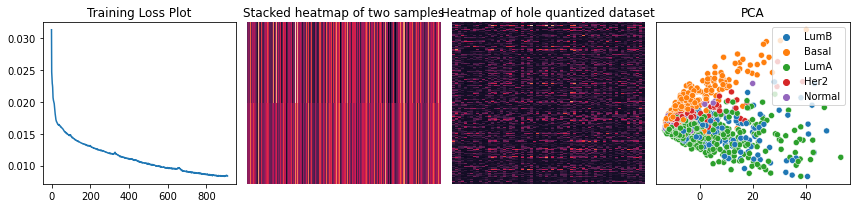

 10%|▉         | 969/10000 [11:56<3:19:34,  1.33s/it]

In [19]:
EPOCH = 10000

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr= 1e-5)
print(optimizer.param_groups[0]['lr'])

model.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    
    # Training loop
    for _, inputs in enumerate(dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        # Compute the VAE loss or standard loss
        if model.is_variational:
            outputs, mu, log_var = model(inputs)
            reconstruction_loss = F.mse_loss(outputs, inputs)
            kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconstruction_loss + (1 * kld)
        else:
            outputs = model(inputs)
            loss = F.mse_loss(outputs, inputs)
        
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
    
    # Calculate and store training loss for this epoch
    train_loss = running_loss / count
    monitor.append_loss(train_loss)
    callbacks(epoch)


print(optimizer.param_groups[0]['lr'])
#RuntimeError: The size of tensor a (9189) must match the size of tensor b (9135) at non-singleton dimension 2


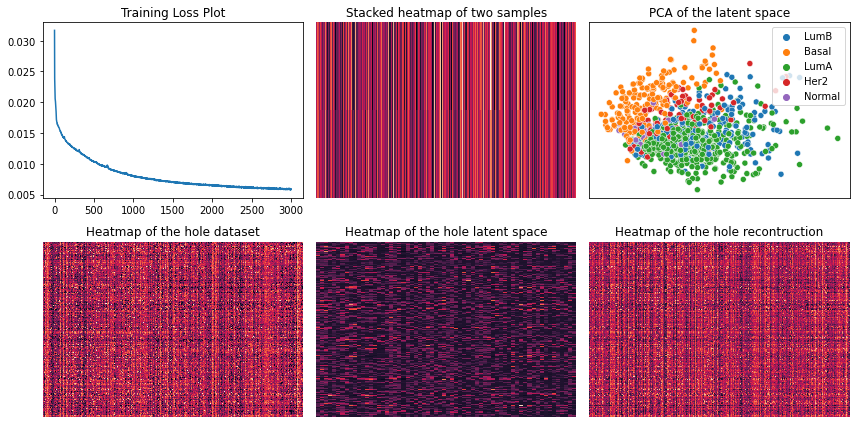

In [15]:
importlib.reload(visualisation)
visualisation.post_training_viz(data, dataloader, model, DEVICE, monitor.train_res_recon_error, labels = metadata["subtypes"])

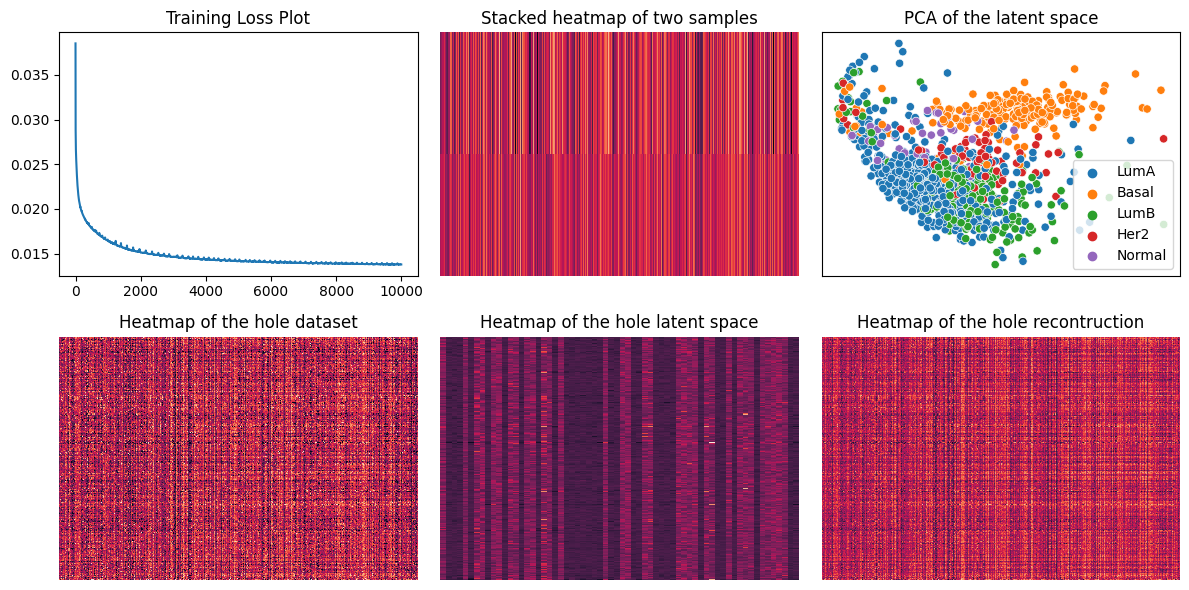

In [8]:
importlib.reload(visualisation)
visualisation.post_training_viz(data, dataloader, model, DEVICE, monitor.train_res_recon_error, labels = metadata["subtypes"])

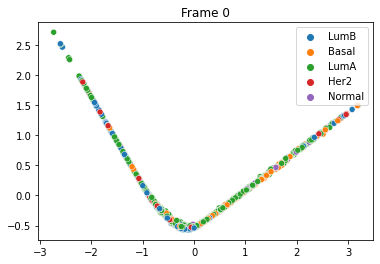

In [16]:
# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Define an update function for the animation
def update(frame):
    ax.clear()
    ax.set_title(f'Frame {frame}')
    
    # Get the PCA result for the current frame
    pca_result = monitor.frames[frame]
    
    # Scatter plot of PCA results with color based on index
    sns.scatterplot(x=pca_result[:, 1], y=pca_result[:, 2], hue=metadata["subtypes"])


# Create the animation
ani = FuncAnimation(fig, update, frames=len(monitor.frames), repeat=True)

# Display the animation as HTML
HTML(ani.to_jshtml())

In [12]:
anim_filename = None
if model.is_variational:
    if model.use_convolution:
        anim_filename= '../img/GDS_pca_convVAE_0.html'
    else:
        anim_filename = '../img/GDS_pca_VAE_0.html'

else:
    if model.use_convolution:
        anim_filename = '../img/GDS_pca_convAE_0.html'
    else:
        anim_filename = '../img/GDS_pca_AE_0.html'
print(anim_filename)

../img/GDS_pca_convAE_0.mp4


In [17]:
with open(anim_filename, 'w') as f:
    f.write(ani.to_jshtml())

In [45]:
torch.save(model, "../workfiles/torch_convAE_GDS_0")

# auto clustering

<Axes: >

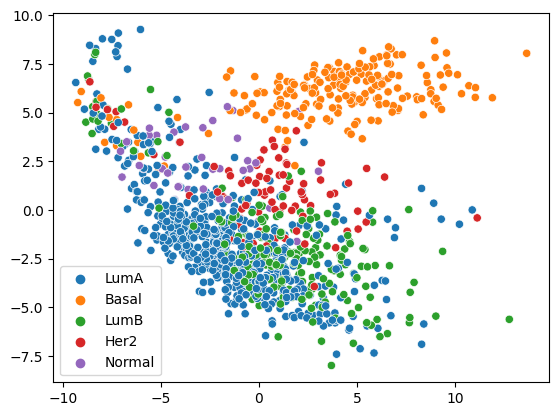

In [70]:
# sometimes you just want a sigle PCA

importlib.reload(helpers)
encode_out, reconstruction_out = helpers.encode_recon_dataset(dataloader, model, DEVICE)

# PCA of the latent space
pca = PCA(n_components=2)
pca.fit(encode_out)
pca_result = pca.transform(encode_out)

sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=metadata["subtypes"])


C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette score for 5 clusters: 0.1501309871673584


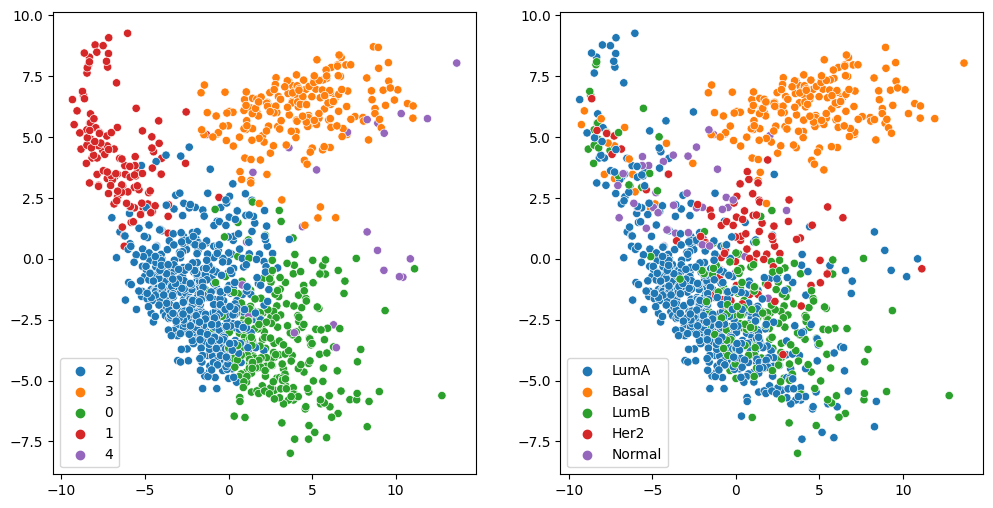

In [83]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Assuming you've determined that you want 3 clusters
n_clusters = 5

# Initialize the KMeans model
kmeans = KMeans(n_clusters=n_clusters)

# Fit the model on your data
kmeans.fit(encode_out)

# Get the cluster assignments
labels = kmeans.labels_

# Calculate silhouette score
silhouette_avg = silhouette_score(encode_out, labels)
print(f"Silhouette score for {n_clusters} clusters: {silhouette_avg}")

# Visualization: Assuming you have 2D data, you can also visualize the clusters:
# (This is for illustration. If your data is not 2D, additional steps are needed for plotting, like PCA to reduce dimensions before plotting.)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=[str(l) for l in labels], ax=axs[0])
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=metadata["subtypes"], ax=axs[1])


plt.show()

#labels
#metadata["subtypes"]

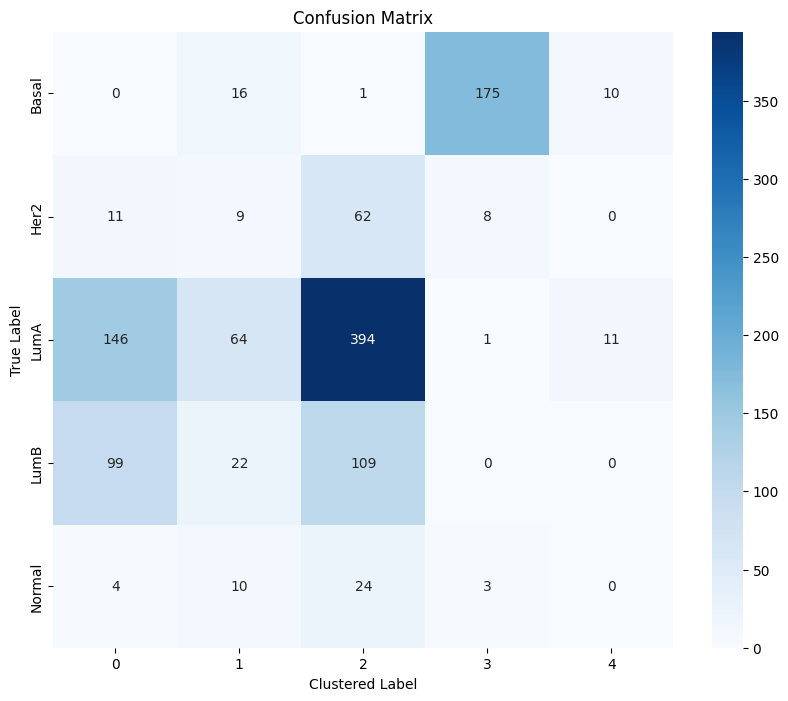

Adjusted Rand Index (ARI): 0.24
Normalized Mutual Information (NMI): 0.32
Fowlkes-Mallows Index: 0.50
Homogeneity: 0.32
Completeness: 0.32
V-measure: 0.32
Silhouette Score: -0.02


In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, homogeneity_completeness_v_measure

# These are your cluster labels and true labels.
# They should be assigned with your actual data.
y_pred = labels  # replace with your actual labels
y_true = metadata["subtypes"]  # replace with your actual clustering results


# Filter out None values
y_pred = [label for label, test in zip(y_pred, y_true) if test is not None]
y_true = [label for label in y_true if label is not None]
X_filtered = [x for x, test in zip(encode_out, y_true) if test is not None]
# Ensure you apply the same filter to the associated data if needed

# Continue with your process using y_true_filtered and y_pred_filtered


# Continue with your process using y_true_no_none and y_pred_no_none instead


# Because your labels might not be integers, or might not start from zero, or not consecutive, we create mappings to ensure the confusion matrix is created correctly.
true_labels = np.unique(y_true)
pred_labels = np.unique(y_pred)

# Create a mapping for true labels
true_label_mapping = {label: idx for idx, label in enumerate(true_labels)}
y_true_mapped = np.array([true_label_mapping[label] for label in y_true])

# Create a mapping for predicted labels
pred_label_mapping = {label: idx for idx, label in enumerate(pred_labels)}
y_pred_mapped = np.array([pred_label_mapping[label] for label in y_pred])

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=pred_labels, yticklabels=true_labels)
plt.ylabel('True Label')
plt.xlabel('Clustered Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(y_true, y_pred)
print(f"Adjusted Rand Index (ARI): {ari_score:.2f}")

# Calculate Normalized Mutual Information (NMI)
nmi_score = normalized_mutual_info_score(y_true, y_pred, average_method='arithmetic')
print(f"Normalized Mutual Information (NMI): {nmi_score:.2f}")







# Calculate Fowlkes-Mallows Index
fm_score = fowlkes_mallows_score(y_true, y_pred)  # or use y_true_filtered, y_pred_filtered
print(f"Fowlkes-Mallows Index: {fm_score:.2f}")

# Calculate Homogeneity, Completeness, and V-measure
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y_true, y_pred)  # or use y_true_filtered, y_pred_filtered
print(f"Homogeneity: {homogeneity:.2f}")
print(f"Completeness: {completeness:.2f}")
print(f"V-measure: {v_measure:.2f}")


silhouette_avg = silhouette_score(X_filtered, y_pred)  # or use y_pred_filtered, depending on your chosen approach
print(f"Silhouette Score: {silhouette_avg:.2f}")